### Loading Image

In [1]:
import cv2
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt

In [3]:
# Load the image
im = cv2.imread('utils/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(im)

In [4]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Normalize the image
gray_image = gray_image / 255.0

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(gray_image, cmap='gray')

In [10]:
# Perform Laplacian of Gaussian (LoG) blob detection
# Parameters: max_sigma is the largest possible blob size, num_sigma defines the number of intermediate values for sigma
blobs_log = blob_log(gray_image, max_sigma=30, num_sigma=10, threshold=0.05)

# Compute radii in the 3rd column
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

# Draw detected blobs
fig, ax = plt.subplots()
ax.imshow(im)

# Loop through blobs and plot them
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

# Show the plot with the detected blobs
plt.show()

In [8]:
# Report parameters of the largest circles
largest_blobs = blobs_log[np.argsort(blobs_log[:, 2])[-5:]]  # Get the largest 5 blobs

# Print the parameters of the largest circles
for i, blob in enumerate(largest_blobs):
    y, x, r = blob
    print(f"Circle {i+1}: Center=({x:.2f}, {y:.2f}), Radius={r:.2f}")

# Report the range of sigma values used
print("Range of sigma values used: 0 to 30")

Circle 1: Center=(283.00, 359.00), Radius=33.31
Circle 2: Center=(0.00, 142.00), Radius=33.31
Circle 3: Center=(0.00, 53.00), Radius=42.43
Circle 4: Center=(106.00, 143.00), Radius=42.43
Circle 5: Center=(234.00, 0.00), Radius=42.43
Range of sigma values used: 0 to 30


In [16]:
import cv2
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt

# Load the image
image_path = 'utils/the_berry_farms_sunflower_field.jpeg'
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Could not load the image at path: {image_path}")

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize the image (optional but helps with blob detection)
gray_image = gray_image / 255.0

# Perform Laplacian of Gaussian (LoG) blob detection
blobs_log = blob_log(gray_image, max_sigma=30, num_sigma=10, threshold=0.5)

# Compute radii for blobs
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

# Plot the detected blobs on the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB

# Loop through detected blobs and draw circles
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

# Show the plot with the blobs detected
plt.title('Detected Blobs in the Sunflower Field')
plt.axis('off')
plt.show()

# Report the parameters of the largest blobs (top 5 largest)
largest_blobs = blobs_log[np.argsort(blobs_log[:, 2])[-5:]]  # Get the largest 5 blobs by radius

print("Top 5 Largest Blobs:")
for i, blob in enumerate(largest_blobs):
    y, x, r = blob
    print(f"Blob {i+1}: Center=({x:.2f}, {y:.2f}), Radius={r:.2f}")

# Optional: Save the image with detected blobs
#output_path = '/mnt/data/sunflower_blobs_detected.jpeg'
#cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


Top 5 Largest Blobs:


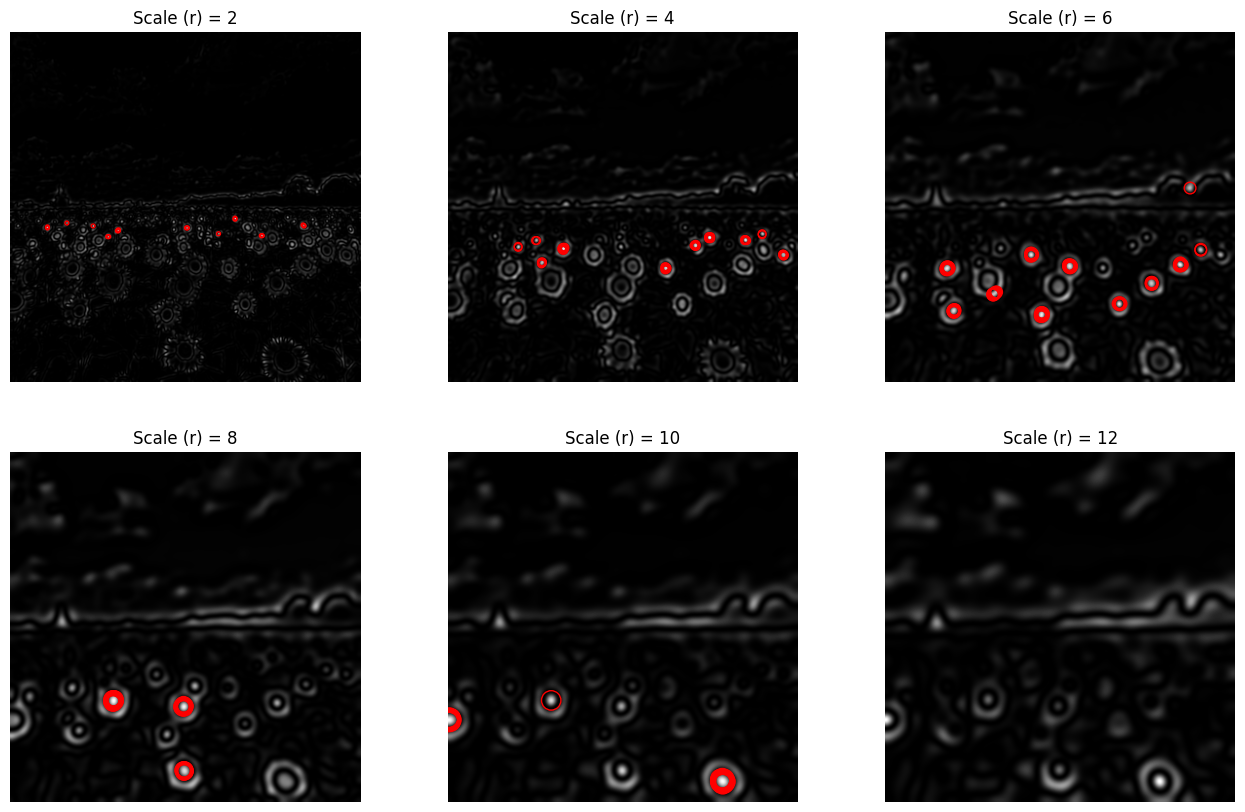

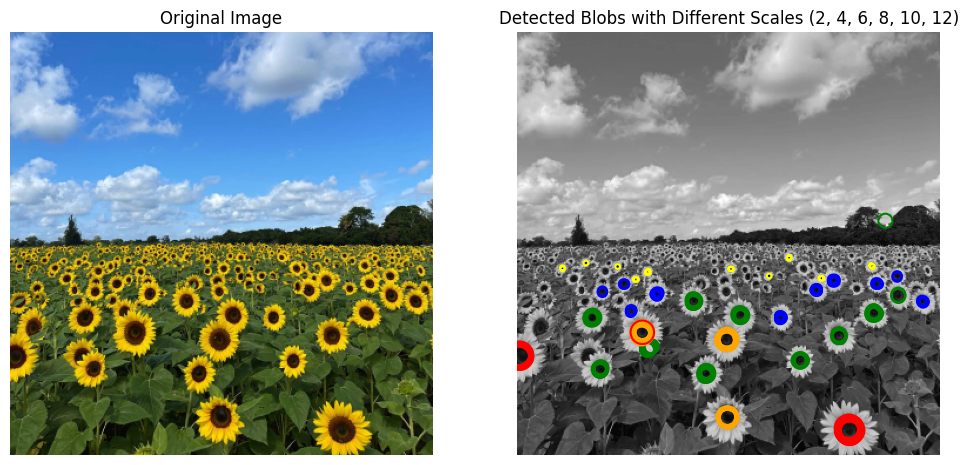

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def generate_log_kernel(sigma):
    """Generate Laplacian of Gaussian (LoG) kernel."""
    radius = int(3 * sigma)
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    kernel = ((x**2 + y**2) / (2 * sigma**2) - 1) * np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    return kernel

def find_blob_centers(log_image, sigma):
    """Find local maxima in the LoG response image."""
    coords = []
    height, width = log_image.shape
    neighborhood = 1  # 3x3 window size
    for row in range(neighborhood, height-neighborhood):
        for col in range(neighborhood, width-neighborhood):
            local_window = log_image[row-neighborhood:row+neighborhood+1, col-neighborhood:col+neighborhood+1]
            max_response = np.max(local_window)
            if max_response >= 0.09:  # Adjust threshold for detection
                x_offset, y_offset = np.unravel_index(np.argmax(local_window), local_window.shape)
                coords.append((row + x_offset - neighborhood, col + y_offset - neighborhood))
    return set(coords)

# Load the image
img_path = 'utils/the_berry_farms_sunflower_field.jpeg'
image = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255.0

# Create a grid of subplots to visualize the results for sigma values r = 2, 4, 6, 8, 10, 12
fig, axis_grid = plt.subplots(2, 3, figsize=(16, 10))

# Loop through sigma values: r = 2, 4, 6, 8, 10, 12
for idx, (r, ax) in enumerate(zip(range(2, 13, 2), axis_grid.flatten())):
    sigma = r / 1.414  # Maintain the same sigma scaling
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply Laplacian of Gaussian filter to the grayscale image
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    
    # Detect blob centers based on the LoG response
    blob_centers = find_blob_centers(log_response, sigma)

    # Display the LoG filtered image
    ax.imshow(log_response, cmap='gray')
    ax.set_title(f'Scale (r) = {r}', fontsize=12)

    # Draw circles around detected blobs
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

    ax.axis('off')

plt.show()

# Display the original image with detected blobs overlayed
fig, (ax_original, ax_overlay) = plt.subplots(1, 2, figsize=(12, 12))

# Show the original image
ax_original.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax_original.set_title("Original Image")
ax_original.axis('off')

# Show the grayscale image with detected blobs overlayed
ax_overlay.imshow(gray_image, cmap='gray')
ax_overlay.set_title("Detected Blobs with Different Scales (2, 4, 6, 8, 10, 12)")
ax_overlay.axis('off')

# List of colors for different blob scales
color_palette = ['yellow', 'blue', 'green', 'orange', 'red', 'purple']

# Loop through the same sigma values: r = 2, 4, 6, 8, 10, 12
for i, r in enumerate(range(2, 13, 2)):
    sigma = r / 1.414
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply LoG filter and find blobs
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    blob_centers = find_blob_centers(log_response, sigma)

    # Draw blobs as circles with different colors based on the scale
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color=color_palette[i], linewidth=1.5, fill=False)
        ax_overlay.add_patch(circle)

# Show the final plot
plt.show()

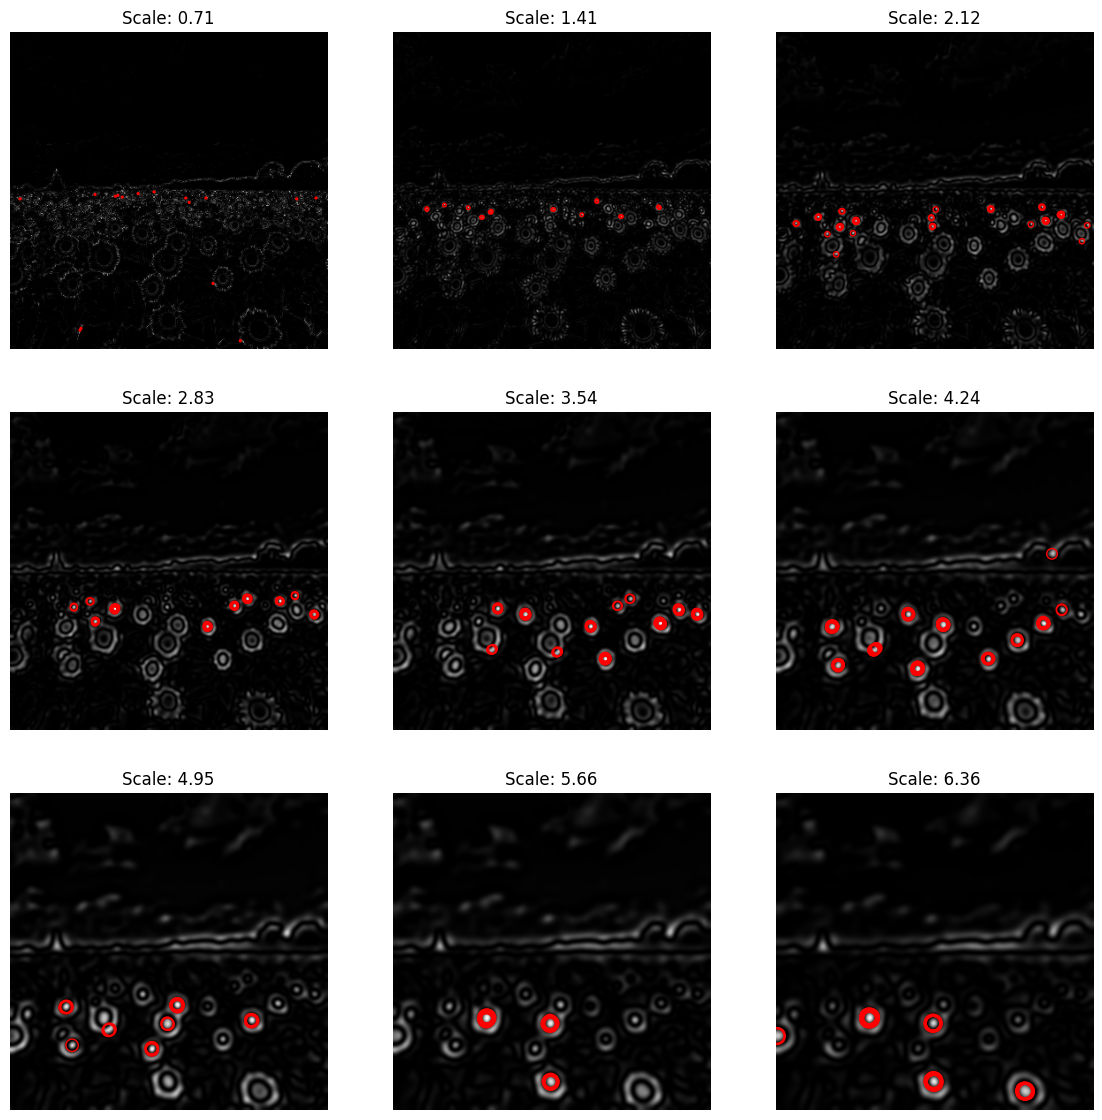

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

def generate_log_kernel(sigma):
    """Generate Laplacian of Gaussian (LoG) kernel."""
    radius = int(3 * sigma)
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    kernel = ((x**2 + y**2) / (2 * sigma**2) - 1) * np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    return kernel

def find_blob_centers(log_image, sigma):
    """Find local maxima in the LoG response image."""
    coords = []
    height, width = log_image.shape
    neighborhood = 1  # 3x3 window size
    for row in range(neighborhood, height-neighborhood):
        for col in range(neighborhood, width-neighborhood):
            local_window = log_image[row-neighborhood:row+neighborhood+1, col-neighborhood:col+neighborhood+1]
            max_response = np.max(local_window)
            if max_response >= 0.09:  # Adjust threshold for detection
                x_offset, y_offset = np.unravel_index(np.argmax(local_window), local_window.shape)
                coords.append((row + x_offset - neighborhood, col + y_offset - neighborhood))
    return set(coords)

# Load the image
img_path = 'utils/the_berry_farms_sunflower_field.jpeg'
image = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255.0

# Create a grid of subplots to visualize different scales
fig, axis_grid = plt.subplots(3, 3, figsize=(14, 14))

# Loop through multiple sigma values (scales)
for idx, ax in enumerate(axis_grid.flatten(), start=1):
    sigma = idx / 1.414  # Adjust sigma values for better detection
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply Laplacian of Gaussian filter to the grayscale image
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    
    # Detect blob centers based on the LoG response
    blob_centers = find_blob_centers(log_response, sigma)

    # Display the LoG filtered image
    ax.imshow(log_response, cmap='gray')
    ax.set_title(f'Scale: {sigma:.2f}', fontsize=12)

    # Draw circles around detected blobs
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

    ax.axis('off')

plt.show()

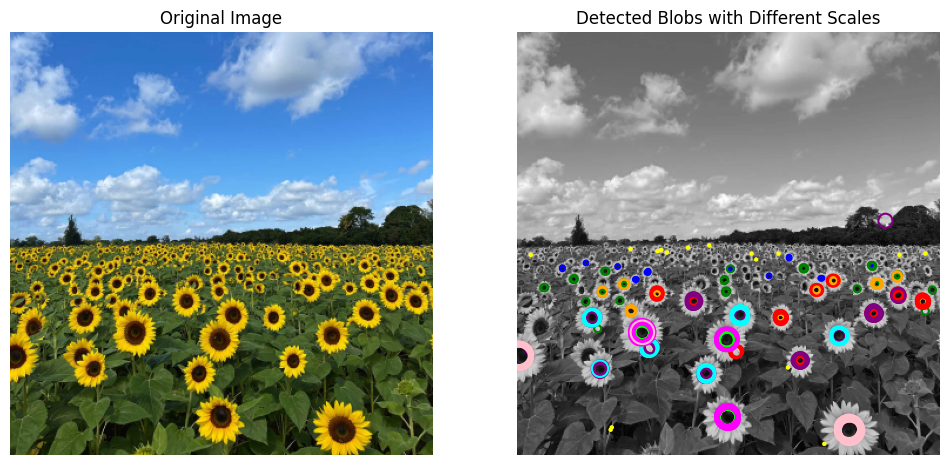

In [18]:
# Display the original image with detected blobs overlayed
fig, (ax_original, ax_overlay) = plt.subplots(1, 2, figsize=(12, 12))

# Show the original image
ax_original.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax_original.set_title("Original Image")
ax_original.axis('off')

# Show the grayscale image with detected blobs overlayed
ax_overlay.imshow(gray_image, cmap='gray')
ax_overlay.set_title("Detected Blobs with Different Scales")
ax_overlay.axis('off')

# List of colors for different blob scales
color_palette = ['yellow', 'blue', 'green', 'orange', 'red', 'purple', 'cyan', 'lime', 'magenta', 'pink']

# Loop through a range of sigma values and overlay the detected blobs on the grayscale image
for i in range(1, 11):
    sigma = i / 1.414
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply LoG filter and find blobs
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    blob_centers = find_blob_centers(log_response, sigma)

    # Draw blobs as circles with different colors based on the scale
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color=color_palette[i-1], linewidth=1.5, fill=False)
        ax_overlay.add_patch(circle)

# Show the final plot
plt.show()